In [54]:
import torch # this first torch import is CRUCIAL for finding the libtorch files!
import numpy as np
import pynbody as pn
import matplotlib.pyplot as plt
import pickle

from time import time
from nesteddict import NestedDict

from sph_lib.deposition import (compute_hsm, 
                                compute_hsm_tensor,
                                p2g
                                )

plt.style.use('~/Desktop/sph_lib/mnras')
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [55]:
compute_results = 1
dataset         = 'cosmo'
dim             = 2 

filename = f'dataset_{dataset}_{dim}d.pkl'
with open(filename, 'rb') as f:
    ds = pickle.load(f)
boxsize = ds['boxsize']

In [56]:
gridnum  = 64
gridnums = [16, 32, 64, 128, 256]

num_nn = 16
nums_nn = [16, 32, 64, 128, 256]

# Integration methods
integrations = ['midpoint', 'trapezoidal', 'simpson']

# Formatting
marker_map = {
    'cic_adaptive': 's',
    'tsc_adaptive': '^',
    'sph_isotropic': 'o',
    'sph_anisotropic': 'd',
}
label_map = {
    'cic_adaptive': 'Adaptive CIC',
    'tsc_adaptive': 'Adaptive TSC',
    'sph_isotropic': 'Isotropic',
    'sph_anisotropic': 'Anisotropic',
}

color_map = {
    'midpoint': 'C0',
    'trapezoidal': 'C1',
    'simpson': 'C2',
}

acc_map = {
    'python': 'Python',
    'cpp': 'C++',
}

In [57]:
# simulation information
periodic = True
extent   = np.array([0, boxsize])

# needed fields
pos      = ds['pos']
masses   = ds['mass']

# computed fields
print(pos.min(), pos.max(), boxsize)
hsm = compute_hsm(pos, num_nn, boxsize)[0]
hmat, eλ, ev = compute_hsm_tensor(pos, masses, num_nn, boxsize)

0.0016350621518917978 14999.99601352585 1.50e+04 Mpc a h**-1


In [58]:
def benchmark_deposition(method, 
                         pos,
                         masses,
                         NN, 
                         gridnum,
                         integration='midpoint',
                         accelerator='python',
                         kernel_name='quintic',
                         hsm=None,
                         hmat=None,
                         ev=None, 
                         eλ=None,
                         return_fields_ngp=False,
                         ):

    # stack all quantities to deposit
    quantities = masses[:, np.newaxis]

    # do we need to average the deposited quantities or not?
    averaged   = [False]
    
    kwargs = {'positions': pos, 
              'quantities': quantities, 
              'averaged': averaged, 
              'extent': extent, 
              'gridnum': gridnum, 
              'periodic': 1,
              'hsm': hsm,
              'num_nn': NN,
              }
    if method in ['sph_anisotropic']:
        kwargs['hmat_eigvecs'] = ev
        kwargs['hmat_eigvals'] = eλ
    
    
    s = time()
    fields_ngp = p2g(**kwargs, 
                     method=method, 
                     accelerator=accelerator, 
                     kernel_name=kernel_name, 
                     integration=integration)
    e = time()
    if return_fields_ngp:
        return fields_ngp, e - s  # return fields and time taken
    else:
        return e - s

#### Benchmark 0: python vs cpp for exact methods

In [59]:
methods = ['ngp', 'cic', 'tsc']
accelerators = ['python', 'cpp']

results = NestedDict()
for acc in accelerators:
    for method in methods:
        results[f'{acc}.{method}'] = NestedDict({'times': []})

for acc in accelerators:
    for method in methods:
        f, t = benchmark_deposition(method, pos, masses, None, gridnum, accelerator=acc, return_fields_ngp=True)
        results[f'{acc}.{method}']['times'].append(t)

with open("results_benchmark_0.pkl", "wb") as f:   # "wb" = write binary
    pickle.dump(results, f)

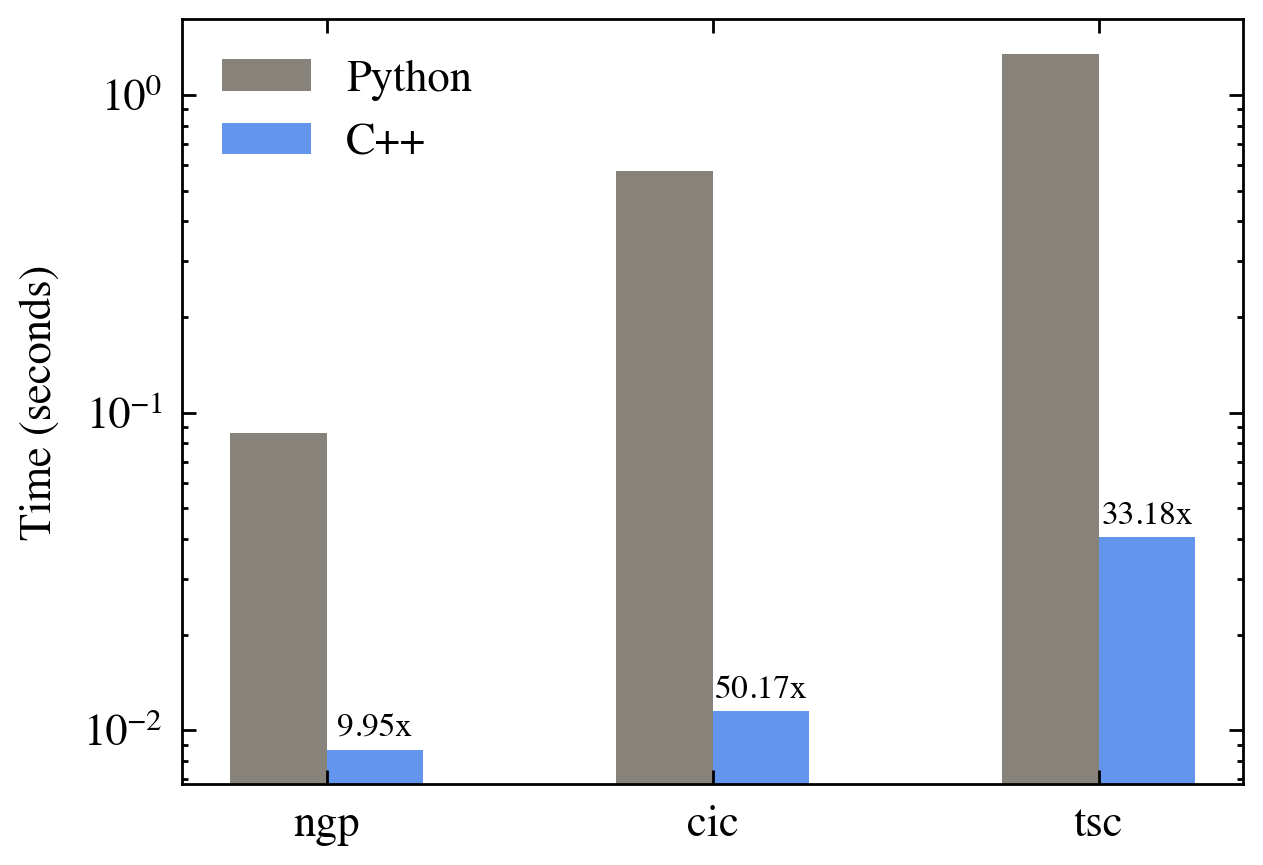

: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator, NullLocator


methods = ['ngp', 'cic', 'tsc']
accelerators = ['python', 'cpp']
colors = ["#87837B", "cornflowerblue"]  # blue for python, orange for cpp

# Example results loaded from pickle
# results[f'{acc}.{method}']['times'] should be scalar or list of length 1
# Let's extract them as floats
data = np.array([[results[f'{acc}.{method}']['times'][0] for acc in accelerators] 
                 for method in methods])  # shape: (num_methods, num_accelerators)

x = np.arange(len(methods))  # positions for methods on x-axis
width = 0.25  # width of each bar

fig, ax = plt.subplots(1, 1)

# Plot bars for each accelerator
bars = []
for i, acc in enumerate(accelerators):
    b = ax.bar(x + i*width - width/2,  # offset so bars are side by side
           data[:, i],
           width=width,
           label=acc_map[acc],
           color=colors[i])
    bars.append(b)

# Compute speedup (Python / C++)
speedup = data[:,0] / data[:,1]

# Annotate on top of C++ bars
for xi, s, bar in zip(x, speedup, bars[1]):  # bars[1] = C++ bars
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2,
            height * 1.05,  # slightly above the bar
            f"{s:.2f}x",
            ha='center', va='bottom', fontsize=6)

# Only major ticks at method positions
ax.xaxis.set_major_locator(FixedLocator(x))
ax.xaxis.set_minor_locator(NullLocator())  # disable minor ticks

ax.set_xticks(x)
ax.set_xticklabels(methods)
ax.set_yscale('log')
ax.set_ylabel('Time (seconds)')
ax.legend()

plt.tight_layout()
plt.savefig('../plots/benchmark_0.png', transparent=True, dpi=300)
plt.show()

#### Benchmark I: number of nearest neighbors

In [ ]:
methods = ['cic_adaptive', 'tsc_adaptive', 'sph_isotropic', 'sph_anisotropic']

results = NestedDict()
for method in methods:
    results[method] = NestedDict({'times': []})

if compute_results:
    for nn in nums_nn:
        print(f'Number of nearest neighbors: {nn}')

        # compute the HSM and HSM tensor once for all methods
        hsm = compute_hsm(pos, nn, boxsize)[0]
        hmat, eλ, ev = compute_hsm_tensor(pos, masses, nn, boxsize)

        for method in methods:
            f, t = benchmark_deposition(method, pos, masses, nn, gridnum, accelerator='cpp', hsm=hsm, hmat=hmat, eλ=eλ, ev=ev, return_fields_ngp=True)
            results[method]['times'].append(t)

    with open("results_benchmark_1.pkl", "wb") as f:
        pickle.dump(results, f)


Number of nearest neighbors: 16
Number of nearest neighbors: 32
Number of nearest neighbors: 64
Number of nearest neighbors: 128
Number of nearest neighbors: 256


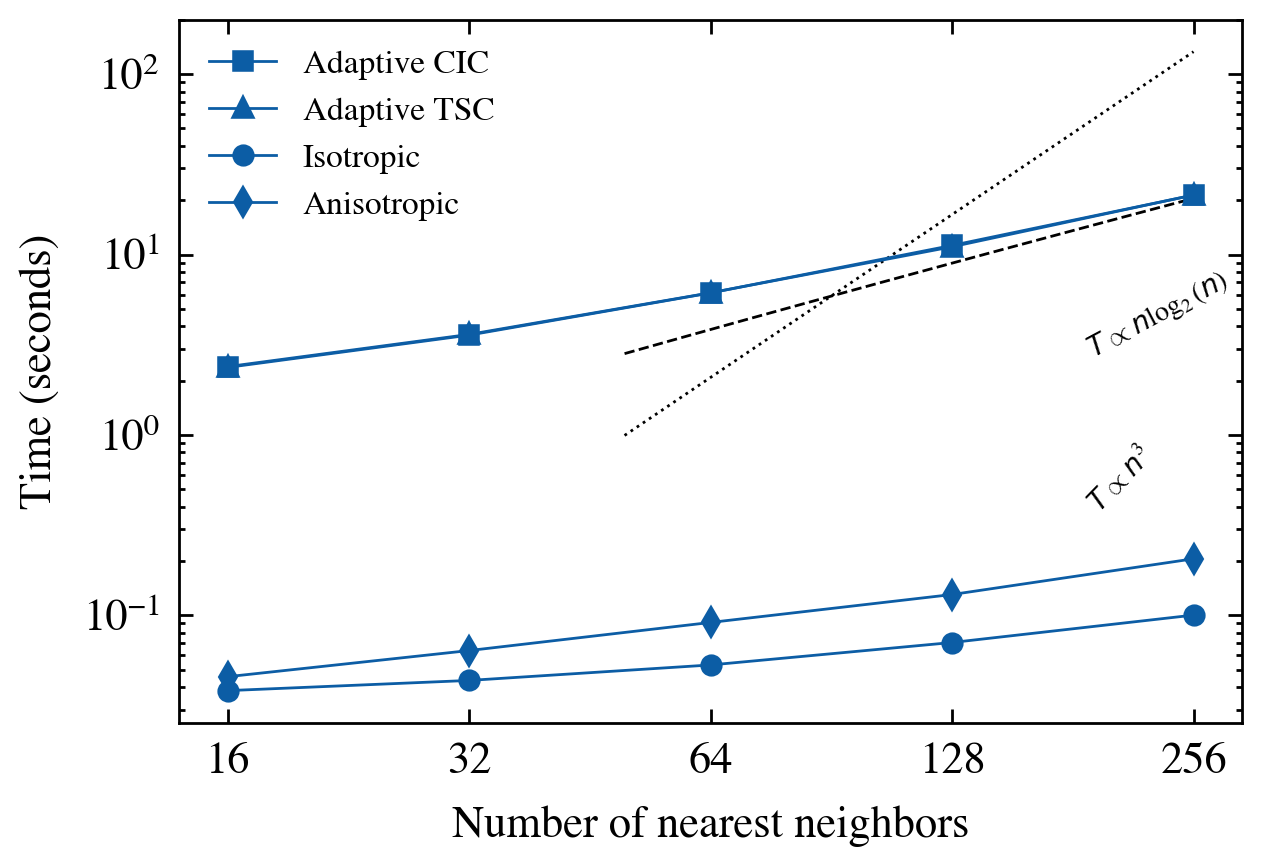

In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullLocator

with open("results_benchmark_1.pkl", "rb") as f:
    results = pickle.load(f)

fig, ax = plt.subplots(1, 1)

# Set light gray background
#ax.set_facecolor("lightgray")

for method in methods:
    ax.plot(np.log2(nums_nn), 
            results[method]['times'], 
            label=label_map[method], 
            marker=marker_map[method],
            lw=0.5,
            markersize=3,
            markeredgecolor='C0',
            markerfacecolor='none'
            )

# Add ideal scaling lines: T ∝ n^3
n_fine = np.logspace(np.log10(50), np.log10(max(nums_nn)), 10)
C_value = 10 ** (-5.1)
D_value = 1e-2
ax.plot(np.log2(n_fine), C_value * n_fine**3, ':', color="k", linewidth=0.5, zorder=-1)
ax.plot(np.log2(n_fine), D_value * n_fine * np.log2(n_fine), '--', color="k", linewidth=0.5, zorder=-1)
ax.text(s=r'$T \propto n \log_{2}(n)$', x=0.85, y=0.52, fontsize=5, transform=ax.transAxes, rotation=28)
ax.text(s=r'$T \propto n^3$', x=0.85, y=0.3, fontsize=5, transform=ax.transAxes, rotation=46)

ax.set_yscale('log')
ax.set_ylabel('Time (seconds)')
ax.set_xlabel('Number of nearest neighbors')
ax.legend(fontsize=6, ncol=1, loc='upper left')

# Force exactly the ticks you want
ax.set_xticks(np.log2(nums_nn))
ax.set_xticklabels(nums_nn)
ax.xaxis.set_minor_locator(NullLocator())  # disable minor ticks

plt.tight_layout()
plt.savefig('../plots/benchmark_1.png', transparent=True, dpi=300)
plt.show()

#### Benchmark II: number of grid cells

In [ ]:
def compute_mass_error(grid_mass, true_mass):
    ratio = np.abs((grid_mass.sum() / true_mass - 1.0)) * 1e2
    return ratio

In [ ]:
true_mass = masses.sum()
methods  = ['sph_isotropic', 'sph_anisotropic']

if compute_results:
    results = NestedDict()
    for method in methods:
        for integration in integrations:
            results[f'{method}.{integration}'] = NestedDict({'times': [], 'error': []})


    # compute the HSM and HSM tensor once for all methods
    #hsm = compute_hsm(pos, num_nn, boxsize)[0]
    #hmat, eλ, ev = compute_hsm_tensor(pos, masses, num_nn, boxsize)


    for gridnum in gridnums:
        print(f'Number grid cells: {gridnum}^3')
        for method in methods:
            for integration in integrations:
                f, t = benchmark_deposition(method, pos, masses, num_nn, gridnum, accelerator='cpp', hsm=hsm, hmat=hmat, eλ=eλ, ev=ev, integration=integration, return_fields_ngp=True)
                results[f'{method}.{integration}']['times'].append(t)
                results[f'{method}.{integration}']['error'].append(compute_mass_error(f, true_mass))

    with open("results_benchmark_2.pkl", "wb") as f:
        pickle.dump(results, f)

Number grid cells: 16^3


/var/folders/g9/6lkt0k991jsbvwhk4pft359m0000gn/T/ipykernel_68411/4060010650.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ratio = np.abs((grid_mass.sum() / true_mass - 1.0)) * 1e2


Number grid cells: 32^3
Number grid cells: 64^3
Number grid cells: 128^3
Number grid cells: 256^3


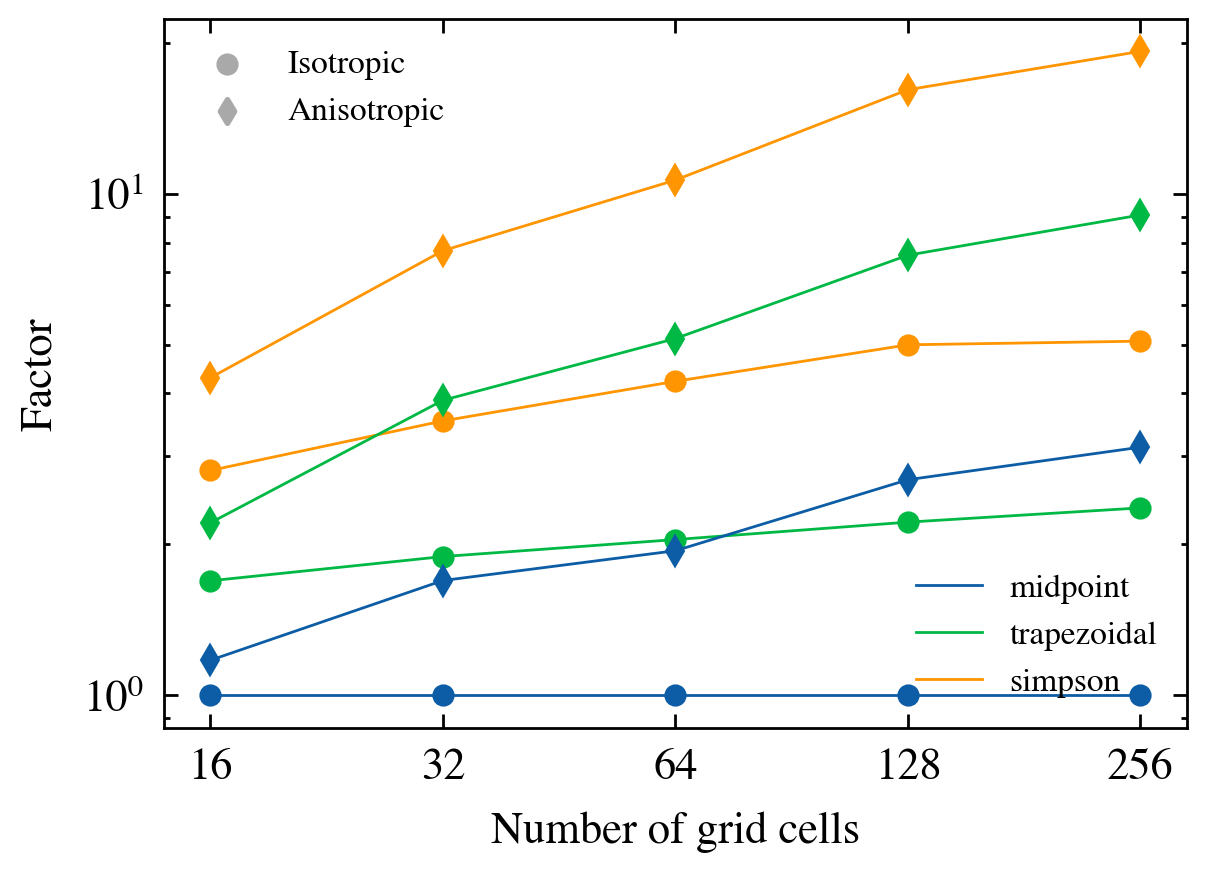

In [ ]:
with open("results_benchmark_2.pkl", "rb") as f:
    results = pickle.load(f)

fig, ax = plt.subplots(1, 1)

# Actual plotted lines
for method in methods:
    for integration in integrations:
        ax.plot(
            np.log2(gridnums), 
            np.asarray(results[f'{method}.{integration}']['times'])  / np.asarray(results[f'{'sph_isotropic'}.{'midpoint'}']['times']), 
            marker=marker_map[method],
            color=color_map[integration],
            linewidth=0.5,
            markersize=3,
        )

# Dummy handles for color legend (integration schemes)
color_handles = []
for integration in integrations:
    h, = ax.plot([], [], 
                 label=integration, 
                 color=color_map[integration],
                 linewidth=0.5,)
    color_handles.append(h)

# Dummy handles for shape legend (isotropic vs anisotropic)
shape_handles = []
for method in methods:
    h = ax.scatter([], [], 
                   label=label_map[method], 
                   marker=marker_map[method],
                   color='darkgrey',
                   s=3**2)
    shape_handles.append(h)

ax.set_yscale('log')
ax.set_ylabel('Factor')
ax.set_xlabel('Number of grid cells')

ax.set_xticks(np.log2(gridnums))
ax.set_xticklabels(gridnums)

from matplotlib.ticker import FixedLocator, FixedFormatter, NullLocator
ax.xaxis.set_major_locator(FixedLocator(np.log2(gridnums)))
ax.xaxis.set_major_formatter(FixedFormatter(gridnums))
ax.xaxis.set_minor_locator(NullLocator())  # disables any minor ticks

# First legend: integration schemes (colors)
legend1 = ax.legend(handles=color_handles, fontsize=6, loc="lower right")

# Second legend: kernel type (shapes)
legend2 = ax.legend(handles=shape_handles, fontsize=6, loc="upper left")

# Add the first legend back
ax.add_artist(legend1)

plt.savefig('../plots/benchmark_2.png', transparent=True, dpi=300)
plt.show()


#### Benchmark III: integration scheme vs mass error

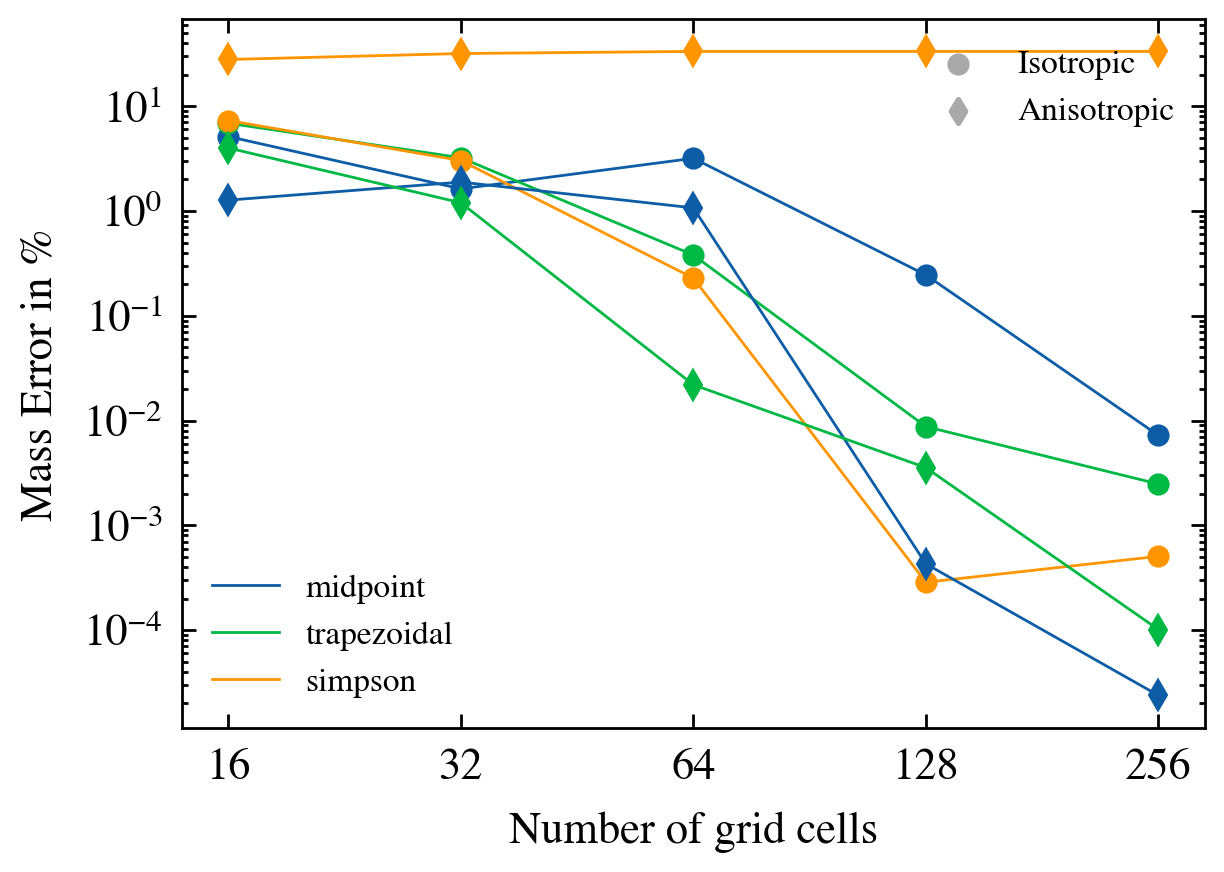

In [ ]:
with open("results_benchmark_2.pkl", "rb") as f:
    results = pickle.load(f)


fig, ax = plt.subplots(1, 1)

for method in methods:
    for integration in integrations:
        ax.plot(np.log2(gridnums), 
                results[f'{method}.{integration}']['error'], 
                #label=f'{integration}', 
                marker=marker_map[method],
                color=color_map[integration],
                linewidth=0.5,
                markersize=3,
        )

# Dummy handles for color legend (integration schemes)
color_handles = []
for integration in integrations:
    h, = ax.plot([], [], 
                 label=integration, 
                 color=color_map[integration],
                 linewidth=0.5,)
    color_handles.append(h)

# Dummy handles for shape legend (isotropic vs anisotropic)
shape_handles = []
for method in methods:
    h = ax.scatter([], [], 
                   label=label_map[method], 
                   marker=marker_map[method],
                   color='darkgrey',
                   s=3**2)
    shape_handles.append(h)

ax.set_yscale('log')
ax.set_xlabel('Number of grid cells')
ax.set_ylabel('Mass Error in %')

ax.set_xticks(np.log2(gridnums))
ax.set_xticklabels(gridnums)

from matplotlib.ticker import FixedLocator, FixedFormatter, NullLocator
ax.xaxis.set_major_locator(FixedLocator(np.log2(gridnums)))
ax.xaxis.set_major_formatter(FixedFormatter(gridnums))
ax.xaxis.set_minor_locator(NullLocator())  # disables any minor ticks


# First legend: integration schemes (colors)
legend1 = ax.legend(handles=color_handles, fontsize=6, loc="lower left")

# Second legend: kernel type (shapes)
legend2 = ax.legend(handles=shape_handles, fontsize=6, loc="upper right")

# Add the first legend back
ax.add_artist(legend1)

plt.savefig('../plots/benchmark_3.png', transparent=True, dpi=300)
plt.show()

#### Benchmark IV: kernel shape vs mass error

In [ ]:
true_mass = masses.sum()
methods = ['sph_isotropic', 'sph_anisotropic']
kernels = ['gaussian', 'super_gaussian', 'cubic', 'quintic', 'wendland_c2', 'wendland_c4', 'wendland_c6']

if compute_results:
    
    results = NestedDict()
    for method in methods:
        for kernel in kernels:
            results[f'{method}.{kernel}'] = NestedDict({'errors': []})

    for gridnum in gridnums:
        print(f'Number grid cells: {gridnum}^3')
        
        for method in methods:
            for kernel in kernels:

                f, t = benchmark_deposition(method, pos, masses, num_nn, gridnum, accelerator='cpp', hsm=hsm, hmat=hmat, eλ=eλ, ev=ev, 
                                            kernel_name=kernel, return_fields_ngp=True)
                results[f'{method}.{kernel}']['errors'].append(compute_mass_error(f, true_mass))

    with open("results_benchmark_4.pkl", "wb") as f:
        pickle.dump(results, f)


Number grid cells: 16^3


/var/folders/g9/6lkt0k991jsbvwhk4pft359m0000gn/T/ipykernel_68411/4060010650.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ratio = np.abs((grid_mass.sum() / true_mass - 1.0)) * 1e2


Number grid cells: 32^3
Number grid cells: 64^3
Number grid cells: 128^3
Number grid cells: 256^3


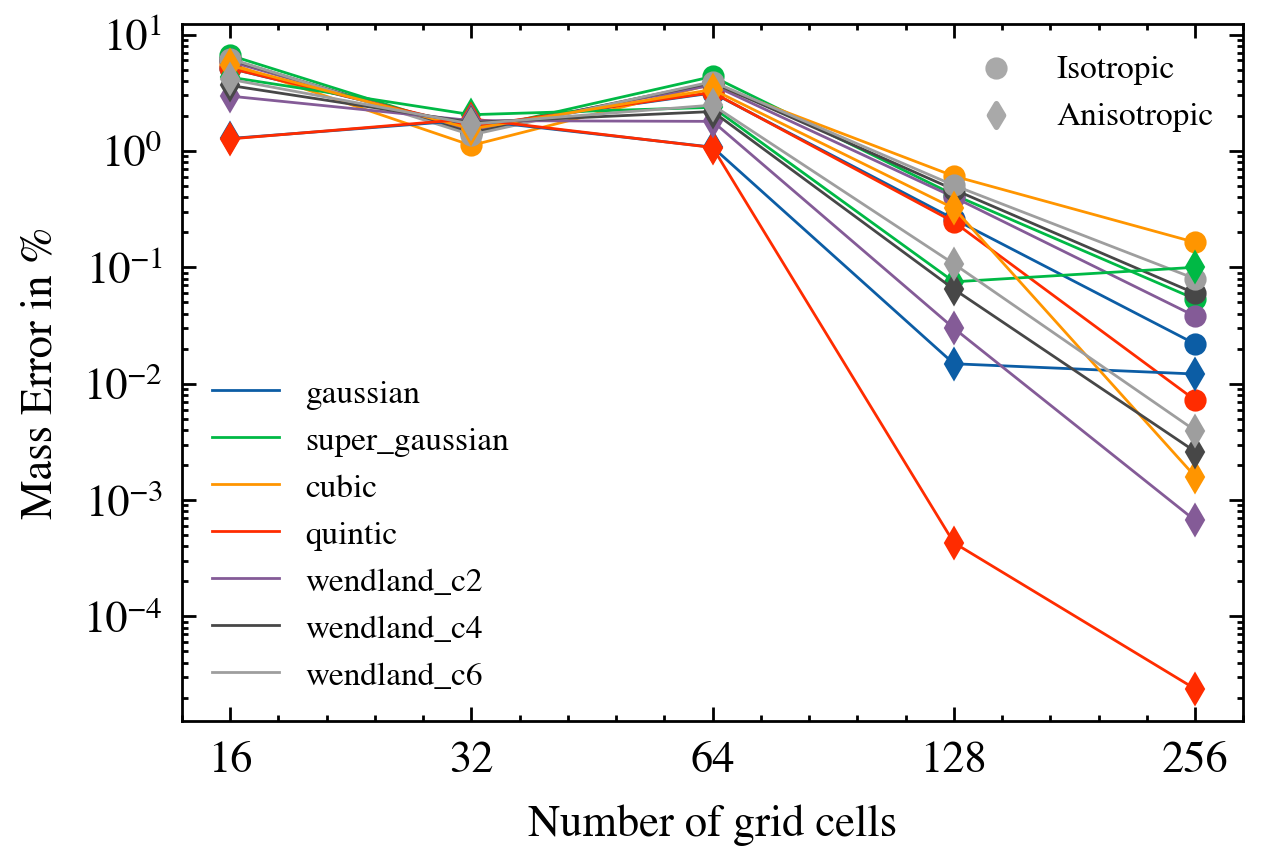

In [ ]:
with open("results_benchmark_4.pkl", "rb") as f:
    results = pickle.load(f)


fig, ax = plt.subplots(1, 1)

# Iterate over nested dicts
for method, kernels_dict in results.items():
    for kernel, val in kernels_dict.items():
        marker = marker_map[method]

        line, = ax.plot(
            np.log2(gridnums),
            val["errors"],
            #label=kernel,
            marker=marker_map[method],
            linestyle="-",
            linewidth=0.5,
            markersize=3,
        )

# Dummy handles for color legend (integration schemes)
color_handles = []
for kernel in kernels:
    h, = ax.plot([], [], 
                 label=kernel, 
                 #color=color_map[integration],
                 linewidth=0.5,)
    color_handles.append(h)

# Dummy handles for shape legend (isotropic vs anisotropic)
shape_handles = []
for method in methods:
    h = ax.scatter([], [], 
                   label=label_map[method], 
                   marker=marker_map[method],
                   color='darkgrey',
                   s=3**2)
    shape_handles.append(h)

# Axis formatting
ax.set_yscale('log')
ax.set_ylabel("Mass Error in %")
ax.set_xlabel("Number of grid cells")
ax.set_xticks(np.log2(gridnums))
ax.set_xticklabels(gridnums)


# First legend: integration schemes (colors)
legend1 = ax.legend(handles=color_handles, fontsize=6, loc="lower left")

# Second legend: kernel type (shapes)
legend2 = ax.legend(handles=shape_handles, fontsize=6, loc="upper right")

# Add the first legend back
ax.add_artist(legend1)

plt.tight_layout()
plt.savefig("../plots/benchmark_4.png", transparent=True, dpi=300)
plt.show()